In [38]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math

In [39]:
PAPERS_CSV = "papers_and_authors.csv"
EDGES_CSV = "edges.csv"

papers_df = pd.read_csv(PAPERS_CSV)
edges_df = pd.read_csv(EDGES_CSV)
papers_df.columns = [c.strip() for c in papers_df.columns]
edges_df.columns = [c.strip() for c in edges_df.columns]

# Build Citation Graph
G = nx.DiGraph()
for _, row in papers_df.iterrows():
    paper_id = str(row["paper_id"]).strip()
    title = str(row["title"]).strip()
    # Handling year field 
    year_val = row["year"]
    if pd.isna(year_val):
        year = 0
    else:
        try:
            # Convert float like 2017.0 → 2017
            year = int(float(year_val))
        except ValueError:
            year = 0
    authors = str(row["authors"]).strip()
    G.add_node(paper_id, title=title, year=year, authors=authors)


for _, row in edges_df.iterrows():
    source = str(row["source"]).strip()
    target = str(row["target"]).strip()
    if source in G.nodes and target in G.nodes:
        G.add_edge(source , target)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph built with 200 nodes and 598 edges


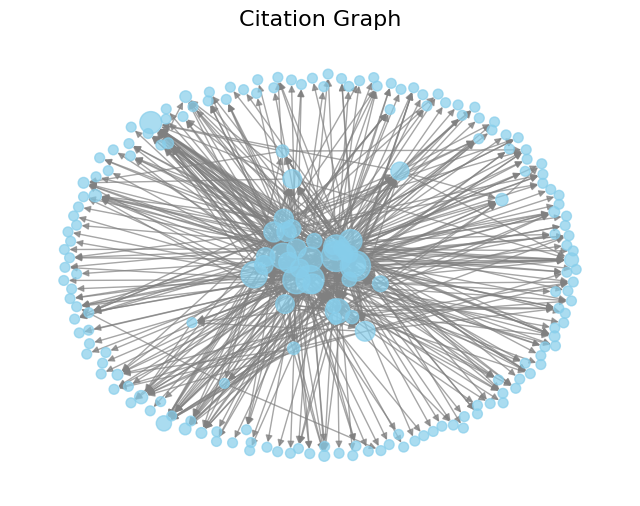

In [40]:
# node size depends on degree (for better visualization)
node_sizes = [max(50, 10 * G.degree(n)) for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,     
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7,
    arrowsize=10
)

plt.title("Citation Graph", fontsize=16)
plt.axis("off")
plt.show()

In [41]:
def Temporal_Weights(G, lambda_decay=0.1):
    years = [data["year"] for _, data in G.nodes(data=True) if data.get("year", 0) > 0]
    Y_max = max(years) if years else 2025
    temporal_weights = {}
    for n, data in G.nodes(data=True):
        y = data.get("year" , Y_max)
        w = math.exp(-lambda_decay * (Y_max - y))
        temporal_weights[n] = w
    return temporal_weights

In [42]:
def compute_temporal_hits(G, temporal_decay, tolerance=1e-6, max_iterations=1000):
    nodes = list(G.nodes())
    temporal_weights = Temporal_Weights(G, temporal_decay)

    # Initialize Hub and Authority scores
    hub = {n: 1.0 for n in nodes}
    auth = {n: 1.0 for n in nodes}

    differences = []

    for iteration in range(max_iterations):

        # --- TEMPORAL AUTHORITY UPDATE ---
        auth_new = {}
        for n in nodes:
            incoming_sum = sum(hub[m] for m in G.predecessors(n))
            auth_new[n] = temporal_weights[n] * incoming_sum  # Apply temporal fairness

        # Normalize authority vector
        norm = sum(v*v for v in auth_new.values()) ** 0.5
        for n in nodes:
            auth_new[n] /= norm

        # --- TEMPORAL HUB UPDATE ---
        hub_new = {}
        for n in nodes:
            outgoing_sum = sum(auth_new[m] for m in G.successors(n))
            hub_new[n] = temporal_weights[n] * outgoing_sum  # Apply temporal fairness

        # Normalize hub vector
        norm = sum(v*v for v in hub_new.values()) ** 0.5
        for n in nodes:
            hub_new[n] /= norm

        # Check difference for convergence
        diff = sum(abs(auth_new[n] - auth[n]) + abs(hub_new[n] - hub[n]) for n in nodes)
        differences.append(diff)

        hub, auth = hub_new, auth_new

        if diff < tolerance:
            print(f"Temporal HITS converged after {iteration+1} iterations.")
            return hub, auth, differences, iteration + 1

    print(f"Reached max iterations ({max_iterations}).")
    return hub, auth, differences, max_iterations


In [43]:
def Analysis(G,temporal_decay):
    hub_scores, auth_scores , Differences , iterations = compute_temporal_hits(G,temporal_decay)
    plt.plot(np.arange(0,iterations),Differences)
    plt.xlabel('Iterations')
    plt.ylabel('Residual')
    plt.show()

    top_papers_by_authorities = sorted(auth_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_papers_by_hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 papers by Authority Scores:")
    for paper_id, score in top_papers_by_authorities:
        print(f"{paper_id[:8]} | ({G.nodes[paper_id]['year']}) - {G.nodes[paper_id]['title'][:60]}... | Score: {score:.4f}")
    
    print("\nTop 10 papers by Hubs Scores:")
    for paper_id, score in top_papers_by_hubs:
        print(f"{paper_id[:8]} | ({G.nodes[paper_id]['year']}) - {G.nodes[paper_id]['title'][:60]}... | Score: {score:.4f}")
    
    top_authority_nodes = [n for n, _ in top_papers_by_authorities]
    top_hub_nodes = [n for n, _ in top_papers_by_hubs]

    # --- Smaller base nodes ---
    node_sizes = [40 for _ in G.nodes()]      # small uniform nodes
    node_colors = ["skyblue" for _ in G.nodes()]   # light blue everywhere
    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)
    plt.figure(figsize=(5, 5))
    # --- Draw base graph ---
    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.5,
        arrowsize=8,
    )
    # --- Now draw only the top nodes as circles with thick borders ---
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_authority_nodes,
        node_size=200,
        node_color="white",              # white fill
        edgecolors="darkred",            # strong border
        linewidths=2.5,                  # border thickness
    )
    # --- Label only the top-10 papers ---
    for n in top_authority_nodes:
        x, y = pos[n]
        plt.text(
            x,
            y + 0.025,
            G.nodes[n]["title"][:25] + "...",
            fontsize=9,
            color="darkred",
            ha="center",
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.7,
                edgecolor="darkred",
                boxstyle="round,pad=0.2"
            )
        )
    plt.title(
        f"Authority Scores(λ = {temporal_decay})",
        fontsize=10
    )
    plt.axis("off")
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(f"Authority_Scores_(λ={temporal_decay}).png")
    plt.show()

    # --- Smaller base nodes ---
    node_sizes = [40 for _ in G.nodes()]      # small uniform nodes
    node_colors = ["skyblue" for _ in G.nodes()]   # light blue everywhere
    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)
    plt.figure(figsize=(5, 5))
    # --- Draw base graph ---
    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.5,
        arrowsize=8,
    )
    # --- Now draw only the top nodes as circles with thick borders ---
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_hub_nodes,
        node_size=200,
        node_color="white",              # white fill
        edgecolors="darkred",            # strong border
        linewidths=2.5,                  # border thickness
    )
    # --- Label only the top-10 papers ---
    for n in top_hub_nodes:
        x, y = pos[n]
        plt.text(
            x,
            y + 0.025,
            G.nodes[n]["title"][:25] + "...",
            fontsize=9,
            color="darkred",
            ha="center",
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.7,
                edgecolor="darkred",
                boxstyle="round,pad=0.2"
            )
        )
    plt.title(
        f"Hubs Scores(λ = {temporal_decay})",
        fontsize=10
    )
    plt.axis("off")
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(f"Hubs_Scores_(λ={temporal_decay}).png")
    plt.show()


Temporal HITS converged after 18 iterations.


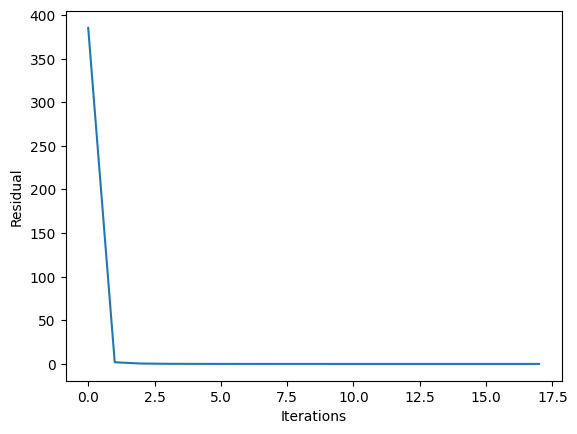

Top 10 papers by Authority Scores:
cea967b5 | (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.3339
0b544dfe | (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.3168
2e9d221c | (1997) - Long Short-Term Memory... | Score: 0.3167
fa72afa9 | (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 0.2997
944a1cfd | (2013) - Recurrent Continuous Translation Models... | Score: 0.2564
6471fd1c | (2013) - Generating Sequences With Recurrent Neural Networks... | Score: 0.1900
93499a7c | (2015) - Effective Approaches to Attention-based Neural Machine Trans... | Score: 0.1763
2c03df8b | (2015) - Deep Residual Learning for Image Recognition... | Score: 0.1669
84069287 | (2012) - On the difficulty of training recurrent neural networks... | Score: 0.1610
a6cb3667 | (2014) - Adam: A Method for Stochastic Optimization... | Score: 0.1568

Top 10 papers by Hubs Scores:
43428880 | (2017) - Convolutional Sequence to Seque

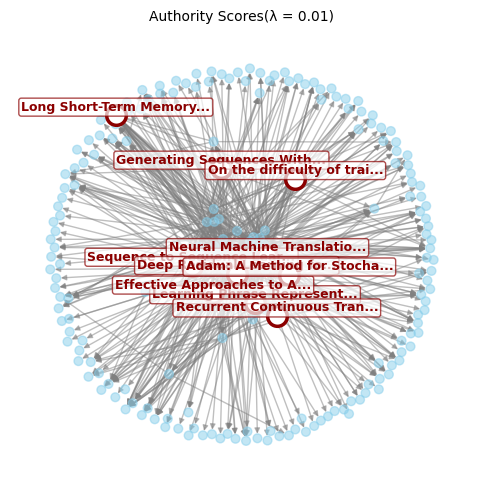

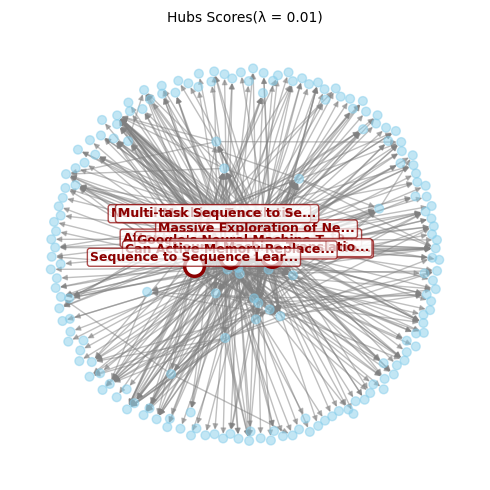

In [44]:
Analysis(G,temporal_decay=0.01)

Temporal HITS converged after 18 iterations.


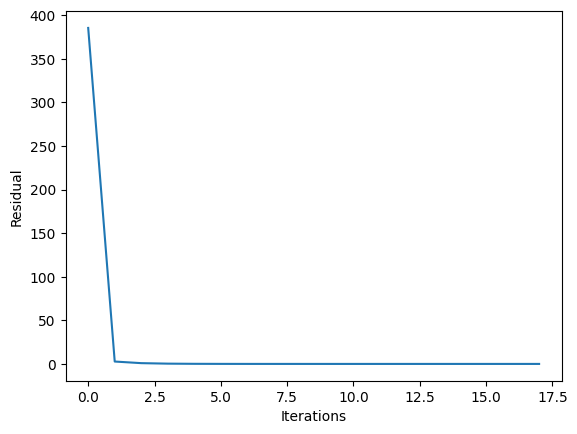

Top 10 papers by Authority Scores:
cea967b5 | (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.3358
fa72afa9 | (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 0.3303
0b544dfe | (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.3114
93499a7c | (2015) - Effective Approaches to Attention-based Neural Machine Trans... | Score: 0.2379
2c03df8b | (2015) - Deep Residual Learning for Image Recognition... | Score: 0.2246
c6850869 | (2016) - Google's Neural Machine Translation System: Bridging the Gap... | Score: 0.2137
944a1cfd | (2013) - Recurrent Continuous Translation Models... | Score: 0.2047
a6cb3667 | (2014) - Adam: A Method for Stochastic Optimization... | Score: 0.1813
1956c239 | (2014) - Addressing the Rare Word Problem in Neural Machine Translati... | Score: 0.1453
1518039b | (2015) - Neural Machine Translation of Rare Words with Subword Units... | Score: 0.1388

Top 10 papers by Hubs Scores:


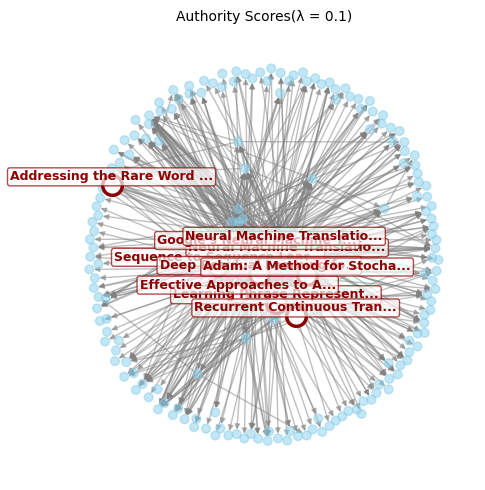

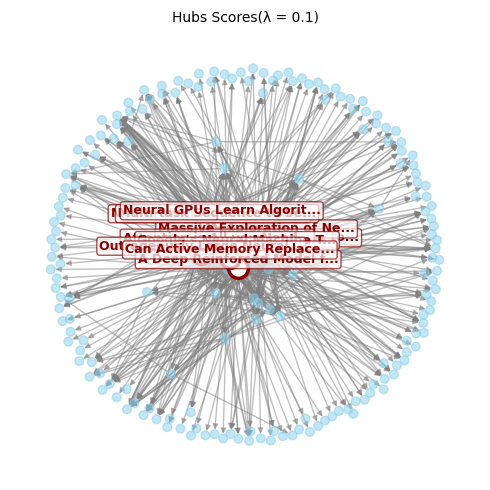

In [45]:
Analysis(G,temporal_decay=0.1)

Temporal HITS converged after 32 iterations.


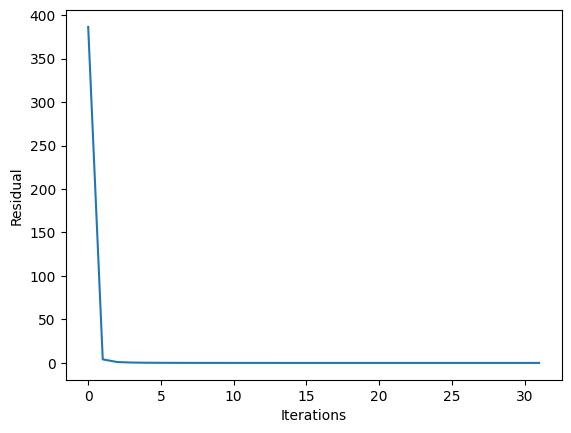

Top 10 papers by Authority Scores:
c6850869 | (2016) - Google's Neural Machine Translation System: Bridging the Gap... | Score: 0.3383
510e2673 | (2017) - Outrageously Large Neural Networks: The Sparsely-Gated Mixtu... | Score: 0.2992
93499a7c | (2015) - Effective Approaches to Attention-based Neural Machine Trans... | Score: 0.2071
2c03df8b | (2015) - Deep Residual Learning for Image Recognition... | Score: 0.2038
bcd857d7 | (2018) - Published as a conference paper at ICLR 2018 S IMULATING A C... | Score: 0.1896
f37076f4 | (2016) - Abstractive Text Summarization using Sequence-to-sequence RN... | Score: 0.1863
fa72afa9 | (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 0.1590
98445f41 | (2016) - Neural Machine Translation in Linear Time... | Score: 0.1558
cea967b5 | (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.1448
f958d492 | (2016) - A Convolutional Encoder Model for Neural Machine Translation... | Score: 0.1441

Top 10 pa

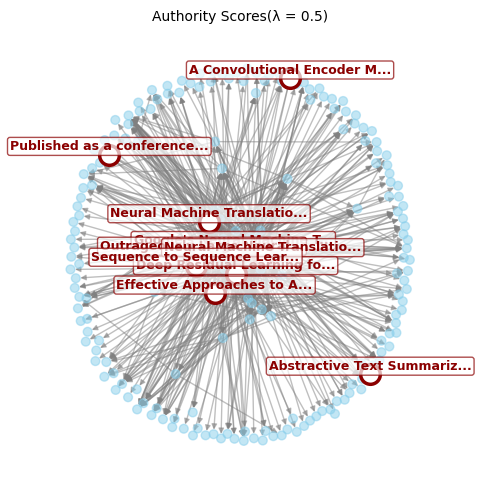

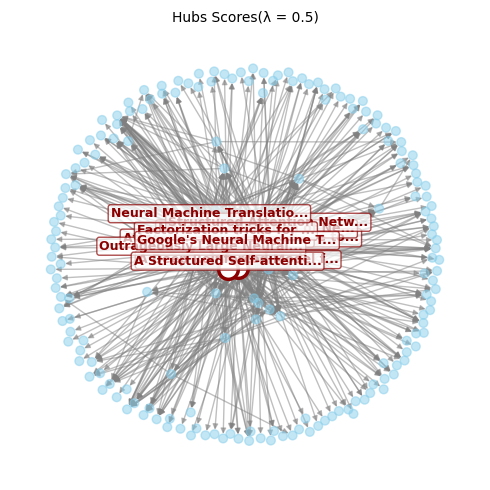

In [46]:
Analysis(G,temporal_decay=0.5)

Temporal HITS converged after 81 iterations.


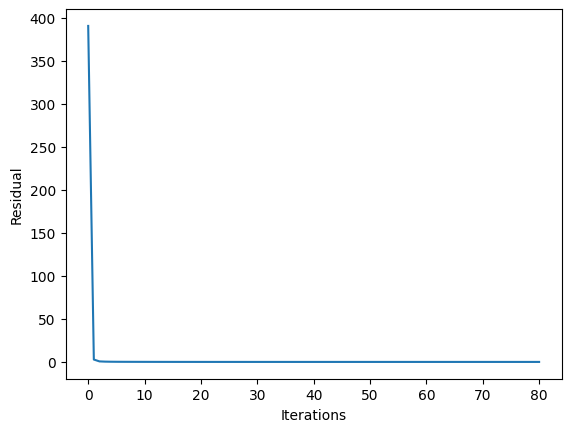

Top 10 papers by Authority Scores:
bcd857d7 | (2018) - Published as a conference paper at ICLR 2018 S IMULATING A C... | Score: 0.5309
510e2673 | (2017) - Outrageously Large Neural Networks: The Sparsely-Gated Mixtu... | Score: 0.4181
c6850869 | (2016) - Google's Neural Machine Translation System: Bridging the Gap... | Score: 0.2349
032274e5 | (2017) - A Deep Reinforced Model for Abstractive Summarization... | Score: 0.1835
43428880 | (2017) - Convolutional Sequence to Sequence Learning... | Score: 0.1835
4550a4c7 | (2017) - Massive Exploration of Neural Machine Translation Architectu... | Score: 0.1835
204a4a70 | (2017) - A Structured Self-attentive Sentence Embedding... | Score: 0.1835
79baf48b | (2017) - Factorization tricks for LSTM networks... | Score: 0.1835
13d9323a | (2017) - Structured Attention Networks... | Score: 0.1835
8fd61ae6 | (2017) - Convolutional Sequence to Sequence Learning... | Score: 0.1701

Top 10 papers by Hubs Scores:
arXiv:17 | (2017) - Attention is All you N

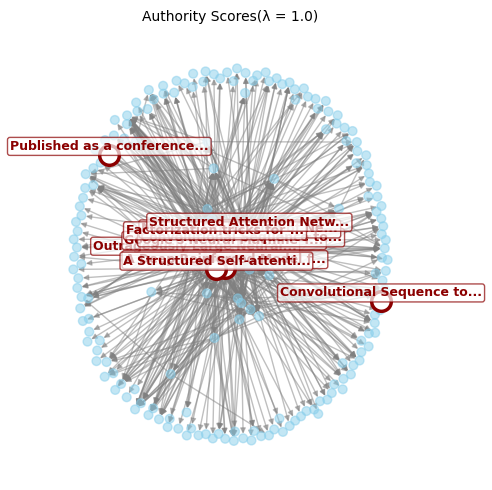

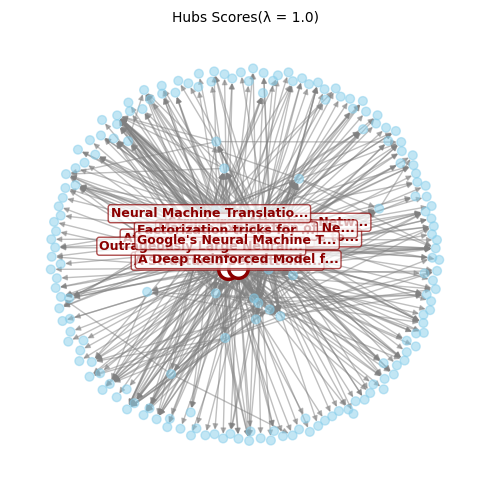

In [47]:
Analysis(G,temporal_decay=1.0)